In [4]:
import tensorflow
print(tensorflow.__version__)
!pip install tensorflow-io
!pip install pathlib

2.18.0


In [18]:
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib
from matplotlib import pyplot as plt
import os
import pathlib
from pathlib import Path
import numpy as np
from IPython.display import display
from IPython.display import Audio
from IPython.core.display import display

/var/folders/hn/32h_k8w94rngtg6ntjfq_mm40000gn/T/ipykernel_57679/3659903053.py:13: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [19]:
path='/Users/hotpolarbear/Documents/Programs/Projects/Voice Automation/Voice-Command-Automation-Tensorflow-Arduino/Dataset'
data_dir = Path(path)
commands = np.array(os.listdir(str(data_dir)))
print("COMMANDS :", commands)

COMMANDS : ['eight' '.DS_Store' 'nine' 'three' 'one' 'zero' 'seven' 'two' 'six'
 'five' 'four']


In [24]:
def mono_16k(wav, labels):
    #file_contents = tf.io.read_file(file_path)
    #wav ,sample_rate = tf.audio.decode_wav(file_contents, desired_channels = 1)
    wav = tf.squeeze(wav, axis = -1)
    #sample_rate = tf.cast(sample_rate, dtype= tf.int64)
    #wav = tfio.audio.resample(wav, rate_in = sample_rate, rate_out = 16000)
    return wav, labels

In [25]:
train_data, test_data = tf.keras.utils.audio_dataset_from_directory(
    directory  = data_dir,
    labels='inferred',
    class_names=None,
    batch_size = 64,
    seed = 0,
    validation_split = 0.25,
    subset = "both",
    output_sequence_length = 16000
)

Found 23666 files belonging to 10 classes.
Using 17750 files for training.
Using 5916 files for validation.


In [26]:
labels_list = np.array(train_data.class_names)
labels_list

array(['eight', 'five', 'four', 'nine', 'one', 'seven', 'six', 'three',
       'two', 'zero'], dtype='<U5')

In [27]:
train_data = train_data.map(mono_16k, tf.data.AUTOTUNE)
test_data = test_data.map(mono_16k, tf.data.AUTOTUNE)

In [28]:
for x_audio, x_label in train_data.take(1):
    print(x_audio.shape)
    print(x_label.shape)

(64, 16000)
(64,)


2025-01-22 17:36:25.150914: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


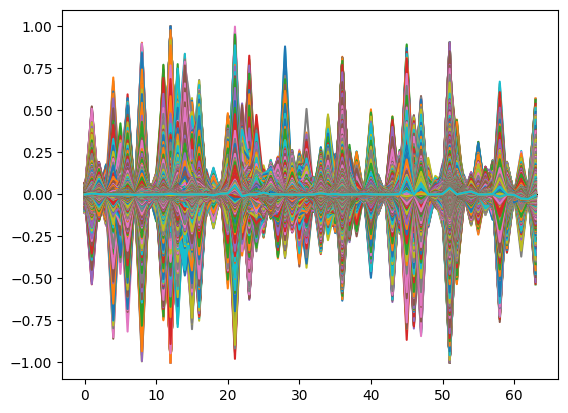

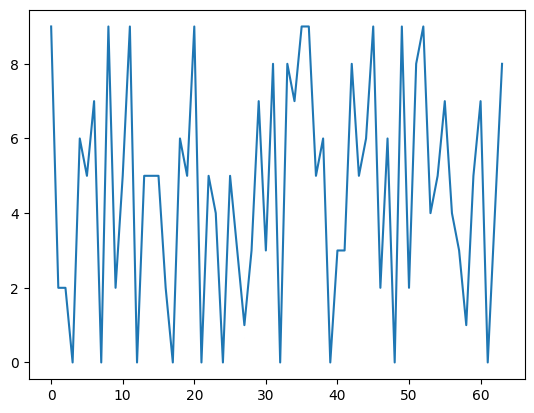

In [30]:
waves = train_data.as_numpy_iterator().next()
for wave in waves:
    
    plt.plot(wave)
    plt.show()

In [31]:
def make_spectrogram(wav):
    spectrogram = tf.signal.stft(wav, frame_length= 320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis =2)
    return spectrogram

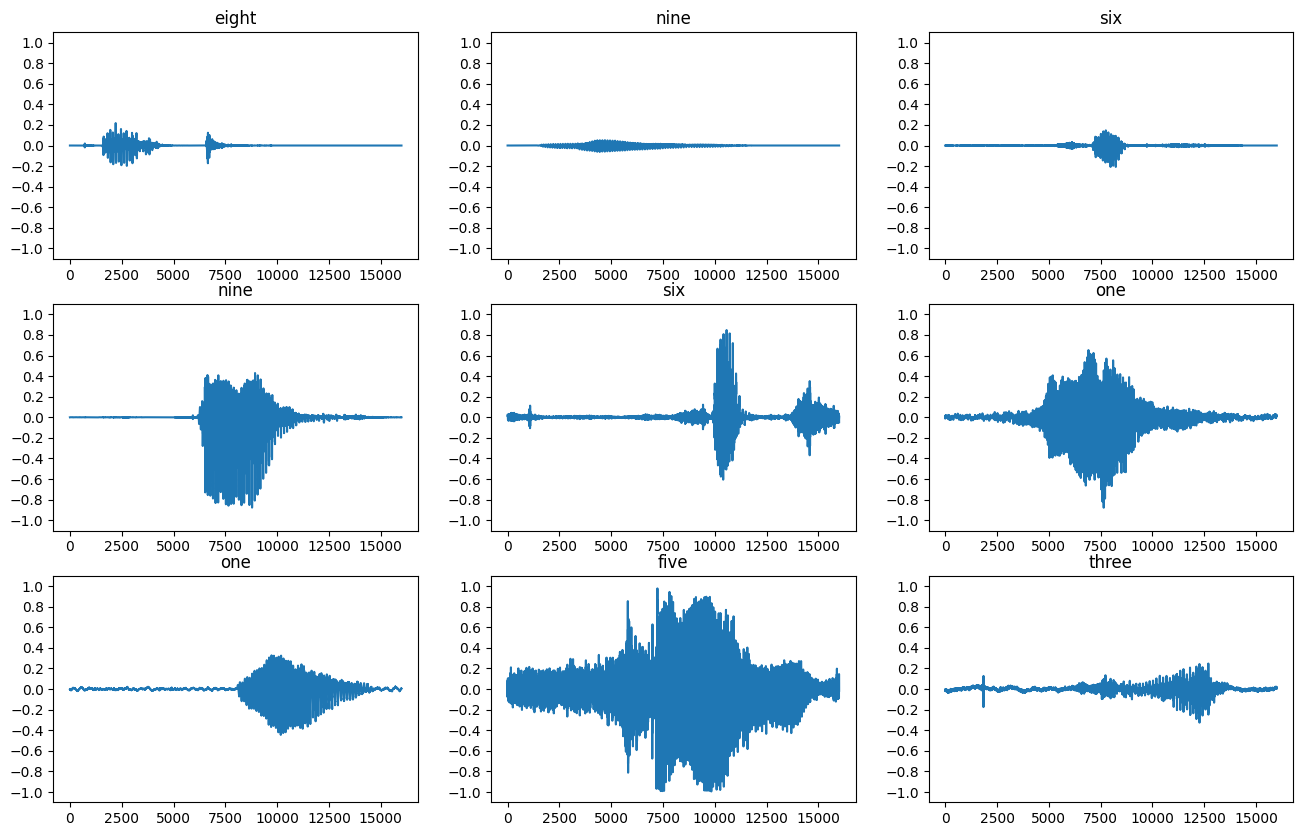

In [32]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = x_audio[i]
  plt.plot(audio_signal)
  plt.title(labels_list[x_label[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [33]:
for i in range(3):
  label = labels_list[x_label[i]]
  waveform = x_audio[i]
  spectrogram = make_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display(Audio(waveform, rate=16000))

Label: eight
Waveform shape: (16000,)
Spectrogram shape: (491, 257, 1)
Audio playback


Label: nine
Waveform shape: (16000,)
Spectrogram shape: (491, 257, 1)
Audio playback


Label: six
Waveform shape: (16000,)
Spectrogram shape: (491, 257, 1)
Audio playback


In [34]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

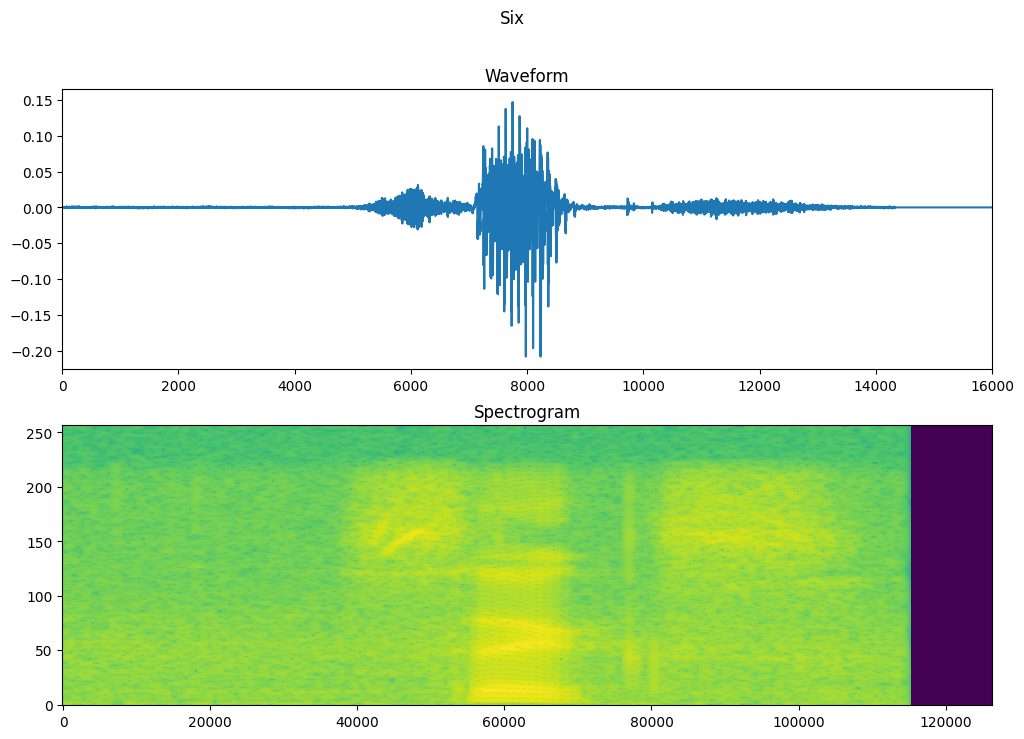

In [35]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [37]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (make_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_data)
test_spectrogram_ds = make_spec_ds(test_data)

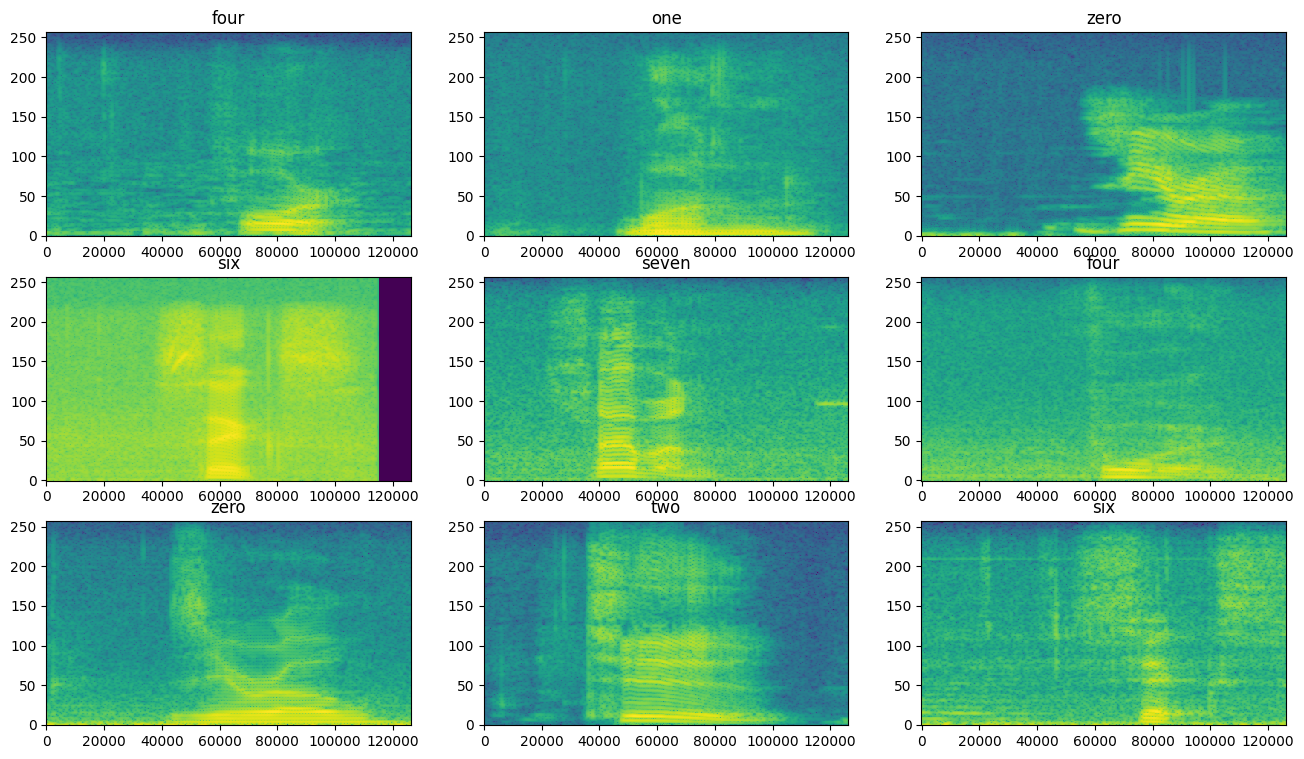

In [38]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(labels_list[example_spect_labels[i].numpy()])

plt.show()

In [39]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(labels_list)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 1, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(256, 5, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (491, 1, 257)


2025-01-22 17:39:19.726085: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 257)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 257)    │           515 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 256)    │       409,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,976,333 (22.80 MB)

 Trainable params: 5,975,818 (22.80 MB)

 Non-trainable params: 515 (2.02 KB)

In [41]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [42]:
EPOCHS = 100
history = model.fit(
    train_spectrogram_ds,
    validation_data= (test_spectrogram_ds),
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 129s 461ms/step - accuracy: 0.4335 - loss: 1.7313 - val_accuracy: 0.8193 - val_loss: 0.6060
Epoch 2/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 130s 466ms/step - accuracy: 0.8178 - loss: 0.6346 - val_accuracy: 0.8644 - val_loss: 0.4734
Epoch 3/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 146s 524ms/step - accuracy: 0.8697 - loss: 0.4447 - val_accuracy: 0.8840 - val_loss: 0.4240
Epoch 4/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 147s 530ms/step - accuracy: 0.8852 - loss: 0.3855 - val_accuracy: 0.9020 - val_loss: 0.3542
Epoch 5/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 145s 522ms/step - accuracy: 0.9031 - loss: 0.3320 - val_accuracy: 0.9111 - val_loss: 0.3312
Epoch 6/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 149s 535ms/step - accuracy: 0.8998 - loss: 0.3469 - val_accuracy: 0.9089 - val_loss: 0.3322
Epoch 7/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 151s 541ms/step - accuracy: 0.9111 - loss: 0.2915 - val_accuracy: 0.9089 - val_loss: 0.3561
Epoch 7: early stopping


In [43]:
model.evaluate(test_spectrogram_ds, return_dict=True)

93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.9104 - loss: 0.3447


{'accuracy': 0.9088911414146423, 'loss': 0.35606545209884644}

In [46]:
model.save("Model_23M_9089.keras")